# Sobel dataset
Necessary library

In [ ]:
!pip install tensorflow-gpu==2.0.0-rc0
!git clone https://github.com/ahatamiz/dog-cat-full-dataset.git

     |██▉                             | 33.2MB 52.0MB/s eta 0:00:07ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.7/http/client.py", line 461, in read
    n = self.readinto(b)
  File "/usr/lib/python3.7/http/client.py", line 505, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.7/ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.7/ssl.py", line 929, in read
    return self._sslobj.read(len, buffer)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

CNN example from https://towardsdatascience.com/learning-to-perform-linear-filtering-using-natural-image-data-db289d0b0457

## Preparing Dataset

In [ ]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt

def make_grayscale(img):
    # Transform color image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

def filter_image_sobel(img):
    # Perform filtering to the input image
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(sobelx,cv2.CV_64F,0,1,ksize=3)  # y
    return sobely

def normalize_image255(img):
    # Changes the input image range from (0, 255) to (0, 1)
    img = img/255.0
    return img

def normalize_image(img):
    # Normalizes the input image to range (0, 1) for visualization
    img = img - np.min(img)
    img = img/np.max(img)
    return img

# Get the paths to the training images
train_data_dir = '/content/dog-cat-full-dataset/data/train'
data_dir = train_data_dir

folderpaths = [os.path.join(data_dir, o) for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,o))]
imagepaths = []

for folderpath in folderpaths:
    temppaths = [os.path.join(folderpath, fname) for fname in os.listdir(folderpath) if fname.endswith('.jpg')]
    imagepaths += temppaths
    
# Load and pre-process the training data
images = []
grayimages = []
filteredimages = []

np.random.shuffle(imagepaths)

MAX = 1000
i = 0
for imagepath in imagepaths:
    i += 1
    if i > MAX: break

    print(imagepath)
    img = cv2.imread(imagepath).astype(np.float32)
    img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
    img = normalize_image255(img)
    gray_img = make_grayscale(img)
    filtered_img = filter_image_sobel(gray_img)

    images.append(img)
    grayimages.append(gray_img)
    filteredimages.append(filtered_img)
    
images = np.array(images, dtype='float32')
grayimages = np.array(grayimages, dtype='float32')
filteredimages = np.array(filteredimages, dtype='float32')

# Expand the image dimension to conform with the shape required by keras and tensorflow, inputshape=(..., h, w, nchannels).
grayimages = np.expand_dims(grayimages, -1)
filteredimages = np.expand_dims(filteredimages, -1)

print("images shape: {}".format(images.shape))
print("grayimages shape: {}".format(grayimages.shape))
print("filteredimages shape: {}".format(filteredimages.shape))

/content/dog-cat-full-dataset/data/train/dogs/dog.1367.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.2596.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.779.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.11546.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.7679.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.2740.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.1679.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.10627.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.7363.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.8049.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.4631.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.10711.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.10461.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.3389.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.2390.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.5838.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.959

In [ ]:
print(grayimages.shape)
print(filteredimages.shape)
# print(grayimages)
# print(filteredimages)
for i in range(5):
  cv2_imshow(grayimages[i]*255)
  cv2_imshow(filteredimages[i]*255)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import optimizers

def load_kernel(path='kernels/smiley_32.png'):
    # Load a kernel image into numpy array
    kernel = cv2.imread(path, 0)
    kernel = cv2.bitwise_not(kernel).astype(np.float32)
    # Normalize according to the L2-norm
    kernel = kernel/np.linalg.norm(kernel)
    return kernel
  
def filter_image(img, kernel):
    # Perform filtering to the input image
    convolved = cv2.filter2D(img, cv2.CV_32F, kernel, borderType=cv2.BORDER_CONSTANT)
    return convolved


input_height, input_width = gray_img.shape


def linearcnn_model():
    # Returns a convolutional neural network model with a single linear convolution layer
    model = Sequential()
    model.add(Conv2D(1, (3,3), padding='same', input_shape=(input_height, input_width, 1)))
    # model.add(Conv2D(1, (8,8), padding='same', input_shape=(input_height, input_width, 1)))
    # model.add(Conv2D(1, (8,8), padding='same', input_shape=(input_height, input_width, 1)))
    return model


model = linearcnn_model()
adam = optimizers.Adam(lr=1e-3)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
# model.summary()

number_of_epochs = 20
loss = []
val_loss = []
convweights = []


for epoch in range(number_of_epochs):
    history_temp = model.fit(grayimages, filteredimages,
                        batch_size=1,
                        epochs=1,
                        validation_split=0.2)
    loss.append(history_temp.history['loss'][0])
    val_loss.append(history_temp.history['val_loss'][0])
    convweights.append(model.layers[0].get_weights()[0].squeeze())

Train on 800 samples, validate on 200 samples
800/800 [==============================] - 14s 18ms/sample - loss: 0.2653 - accuracy: 0.0352 - val_loss: 0.2056 - val_accuracy: 0.0308
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 12s 15ms/sample - loss: 0.2210 - accuracy: 0.0352 - val_loss: 0.2017 - val_accuracy: 0.0308
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 12s 16ms/sample - loss: 0.2169 - accuracy: 0.0352 - val_loss: 0.1975 - val_accuracy: 0.0308
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 12s 15ms/sample - loss: 0.2114 - accuracy: 0.0352 - val_loss: 0.1916 - val_accuracy: 0.0308
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 13s 16ms/sample - loss: 0.2038 - accuracy: 0.0352 - val_loss: 0.1837 - val_accuracy: 0.0308
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 13s 16

In [ ]:
for epoch in range(number_of_epochs):
    history_temp = model.fit(grayimages, filteredimages,
                        batch_size=1,
                        epochs=1,
                        validation_split=0.2)
    loss.append(history_temp.history['loss'][0])
    val_loss.append(history_temp.history['val_loss'][0])
    convweights.append(model.layers[0].get_weights()[0].squeeze())

Train on 800 samples, validate on 200 samples
800/800 [==============================] - 13s 16ms/sample - loss: 0.0495 - accuracy: 0.0351 - val_loss: 0.0435 - val_accuracy: 0.0306
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 13s 16ms/sample - loss: 0.0464 - accuracy: 0.0350 - val_loss: 0.0408 - val_accuracy: 0.0306
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 13s 16ms/sample - loss: 0.0441 - accuracy: 0.0350 - val_loss: 0.0387 - val_accuracy: 0.0306
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 12s 15ms/sample - loss: 0.0425 - accuracy: 0.0350 - val_loss: 0.0372 - val_accuracy: 0.0306
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 5s 6ms/sample - loss: 0.0413 - accuracy: 0.0350 - val_loss: 0.0362 - val_accuracy: 0.0306
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 5s 6ms/s

In [ ]:
predicted = model.predict(grayimages[:5])
for i in range(5):
  cv2_imshow(predicted[i]*255)
  cv2_imshow(grayimages[i]*255)

Output hidden; open in https://colab.research.google.com to view.

# Original Code Benchmark

Se

In [ ]:
import numpy as np
image = (np.random.rand(512,512)*255).astype(int)
sobelx = np.array([[1,2,1,],[0,0,0],[-1,-2,-1]])
sobely = np.array([[1,0,-1,],[2,0,-2],[1,0,-1]])

In [ ]:
import time
t = time.time()
for i in range(510):
  for j in range(510):
    image[i:i+3,j:j+3] *= sobelx
    image[i:i+3,j:j+3] *= sobely

time.time() - t

1.3073015213012695

In [ ]:
import numpy as np
import os
import cv2
import time

import matplotlib.pyplot as plt

def make_grayscale(img):
    # Transform color image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

def filter_image_sobel(img):
    # Perform filtering to the input image
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(sobelx,cv2.CV_64F,0,1,ksize=3)  # y
    return sobely

def normalize_image255(img):
    # Changes the input image range from (0, 255) to (0, 1)
    img = img/255.0
    return img

def normalize_image(img):
    # Normalizes the input image to range (0, 1) for visualization
    img = img - np.min(img)
    img = img/np.max(img)
    return img

# Get the paths to the training images
train_data_dir = '/content/dog-cat-full-dataset/data/train'
data_dir = train_data_dir

folderpaths = [os.path.join(data_dir, o) for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,o))]
imagepaths = []

for folderpath in folderpaths:
    temppaths = [os.path.join(folderpath, fname) for fname in os.listdir(folderpath) if fname.endswith('.jpg')]
    imagepaths += temppaths
    
# Load and pre-process the training data
images = []
grayimages = []
filteredimages = []

np.random.shuffle(imagepaths)

MAX = 1000
i = 0
T = 0
for imagepath in imagepaths:
    i += 1
    if i > MAX: break

    print(imagepath)
    img = cv2.imread(imagepath).astype(np.float32)
    img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
    img = normalize_image255(img)

    gray_img = make_grayscale(img)
    t = time.time()
    filtered_img = filter_image_sobel(gray_img)
    T += time.time()-t

print(T/MAX)

/content/dog-cat-full-dataset/data/train/dogs/dog.4393.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.11124.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.5341.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.4373.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.12489.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.8307.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.3152.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.12195.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.12393.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.7464.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.12243.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.7847.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.1657.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.7799.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.6418.jpg
/content/dog-cat-full-dataset/data/train/dogs/dog.4411.jpg
/content/dog-cat-full-dataset/data/train/cats/cat.1

# END

# NN Model CNN, RNN, LSTM, BERT

## LSTM Attempt 1

In [ ]:
from tensorflow.keras import layers 

In [ ]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
batch_size = 64
input_dim = 28
units = 64
output_size = 10
lstm_layer = keras.layers.LSTM(units, input_shape=(input_dim, input_dim))
model = keras.models.Sequential(
    [
        lstm_layer,
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_size),
    ]
    )

In [ ]:
mondel.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 10s 161us/sample - loss: 0.9466 - accuracy: 0.7012 - val_loss: 0.5625 - val_accuracy: 0.8139


In [ ]:
result = model.predict(x_train)

In [ ]:
print( np.argmax(result[1]), y_train[1] )

0 0


In [ ]:
cv2_imshow(x_train[1]*255)

## LSTM Attempt 2

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
batch_size = 64
input_dim = 28
units = 64
output_size = 10
lstm_layer = keras.layers.LSTM(units=28, batch_input_shape=(None,28,28), return_sequences=True)
model = keras.models.Sequential(
    [
        lstm_layer,
    ]
    )
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 28, 28)            6384      
Total params: 6,384
Trainable params: 6,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# x_train = grayimages[:,:,:,0]
# y_train = filteredimages[:,:,:,0]
# print(x_train.shape)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
model.fit(
    x_train, x_train, batch_size=2, epochs=1
)

Train on 60000 samples
    2/60000 [..............................] - ETA: 2:41:02

ValueError: ignored

## Transformer Attempt 1
https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 686kB 8.4MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169009152/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


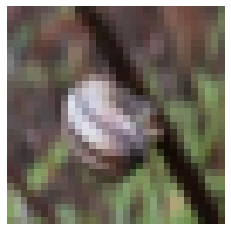

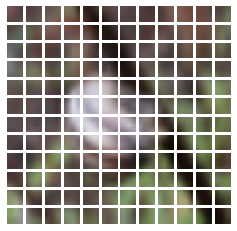

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
176/176 [==============================] - 79s 384ms/step - loss: 4.4762 - accuracy: 0.0456 - top-5-accuracy: 0.1622 - val_loss: 3.9282 - val_accuracy: 0.1012 - val_top-5-accuracy: 0.2954
Epoch 2/100
176/176 [==============================] - 67s 378ms/step - loss: 3.9594 - accuracy: 0.0927 - top-5-accuracy: 0.2845 - val_loss: 3.6158 - val_accuracy: 0.1474 - val_top-5-accuracy: 0.3912
Epoch 3/100
176/176 [==============================] - 67s 379ms/step - loss: 3.7099 - accuracy: 0.1311 - top-5-accuracy: 0.3614 - val_loss: 3.3441 - val_accuracy: 0.1934 - val_top-5-accuracy: 0.4760
Epoch 4/100
176/176 [==============================] - 67s 378ms/step - loss: 3.5407 - accuracy: 0.1551 - top-5-accuracy: 0.4127 - val_loss: 3.2460 - val_accuracy: 0.2160 - val_top-5-accuracy: 0.4932
Epoch 5/100
176/176 [==============================] - 67s 379

KeyboardInterrupt: ignored